In [44]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io.wavfile as wav
import os
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
import glob
import math
import torch.nn as nn
import numpy as np
from bisect import bisect_left
import scipy as sp
import h5py


In [45]:
data_folder = "../datasets/generated_dataset/"
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
dropout = 0.1
batch_size = 128
fs = 16000

max_shift = 500 # in samples
guess_grid_size = max_shift

#f = h5py.File("../datasets/generated_dataset/generated_dataset_easy.hdf5","r")
#f = h5py.File("../datasets/generated_dataset/generated_dataset_medium.hdf5","r")
#f = h5py.File("../datasets/generated_dataset/generated_dataset_hard.hdf5","r")
f = h5py.File("../datasets/generated_dataset/generated_dataset_extreme.hdf5","r")
#f = h5py.File("../datasets/generated_dataset/generated_dataset_real.hdf5","r")


X = f['input']
y = f['gt']

# f_test = h5py.File("../datasets/generated_dataset/generated_dataset_valer.hdf5","r")
# X_test = f_test['input']
# y_test = f_test['gt']

#X = torch.load(os.path.join(data_folder,"input2.pt"))
#y = torch.load(os.path.join(data_folder,"gt2.pt"))
#X_test = torch.load(os.path.join(data_folder,"input.pt"))
#y_test = torch.load(os.path.join(data_folder,"gt.pt"))

class custom_dataset(Dataset):

    def __init__(self, X, y, idx_min=0,dataset_len=len(X)):
        self.X = X
        self.y = y
        self.dataset_len = dataset_len
        self.idx_min = idx_min

    def __getitem__(self, idx):
        return self.X[idx + self.idx_min],self.y[idx + self.idx_min]

    def __len__(self):
        return self.dataset_len

split_i = int(X.shape[0]*0.98)
dataset = custom_dataset(X,y, 0, split_i)
#dataset_test = custom_dataset(X_test,y_test, 0 ,X_test.shape[0])
dataset_test = custom_dataset(X,y, split_i, X.shape[0] - split_i)
#dataset, dataset_test = torch.utils.data.random_split(dataset, [0.98,0.02])
train_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


In [54]:
def augment_shift(X,y, common_shift=True):
    X = torch.complex(X[:,0],X[:,1])

    #augment 1, multiply each of the vectors with phase
    

    max_shift = 100 # number of samples to max_shift
    sample_length = 10000


    imag_unit = torch.complex(torch.tensor(0.0),torch.tensor(1.0))
    if common_shift:
        sample_shift = (torch.rand(X.shape[0],1,1)*2 - 1)*max_shift
        phase_shift = (-sample_shift/sample_length*2*torch.pi*imag_unit*torch.arange(X.shape[1]).unsqueeze(1)).exp()
        new_abf = X*phase_shift
        X = torch.stack([torch.real(new_abf),torch.imag(new_abf)], dim=1)
        
    else:
        sample_shift = (torch.rand(X.shape[0],1,2)*2 - 1)*max_shift
        phase_shift = (-sample_shift/sample_length*2*torch.pi*imag_unit*torch.arange(X.shape[1]).unsqueeze(1)).exp()
        new_abf = X*phase_shift
        X = torch.stack([torch.real(new_abf),torch.imag(new_abf)], dim=1)
        y = y + (sample_shift[:,:,0] - sample_shift[:,:,1]).to(int)
    return (X,y)

def augment_amp(X,y):
    amp_max = 3
    amp_min = 0.2
    amp_change_factor = torch.rand(X.shape)*(amp_max - amp_min) + amp_min
    X = X*amp_change_factor
    return (X,y)


# Single example test

tensor(-63)


/var/folders/m3/_f4v2b3d6yz294_hq5ftj83c0000gn/T/ipykernel_47235/3491225536.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


tensor([-63.6202])

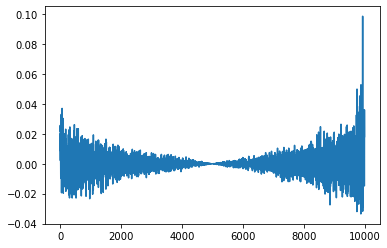

In [55]:

X,y = next(iter(train_dl))
X,y = augment_shift(X,y)
X,y = augment_amp(X,y)
X = torch.tensor(X)
X = torch.complex(X[:,0],X[:,1])

i = 0
c = X[i,:,0]*torch.conj(X[i,:,1])

cc = torch.concatenate([c, torch.zeros(10000 - 2*c.shape[0]),torch.conj(c.flip(dims=(0,)))])
cc = cc /( cc.abs() + 1e-8)

f = torch.fft.ifft(cc)
f = torch.real(f)


plt.plot(f)
w = f.argmax()

if w > 1000:
    w = w - len(f)
print(w)
y[i]

# Histogram over dataset

/var/folders/m3/_f4v2b3d6yz294_hq5ftj83c0000gn/T/ipykernel_47235/3572009010.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


0.25 inliers


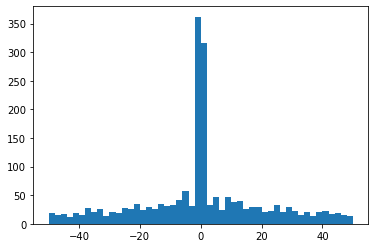

In [48]:
res = []
for X,y in train_dl:
    X = torch.tensor(X)
    X = torch.complex(X[:,0],X[:,1])

    for i in range(X.shape[0]):
        c = X[i,:,0]*torch.conj(X[i,:,1])

        cc = torch.concatenate([c, torch.zeros(10000 - 2*c.shape[0]),torch.conj(c.flip(dims=(0,)))])
        cc = cc /( cc.abs() + 1e-8)

        f = torch.fft.ifft(cc)
        f = torch.real(f)
        w = f.argmax()

        if w > 1000:
            w = w - len(f)
        res.append((y[i] - w).item())
res = torch.tensor(res)        
plt.hist(res, bins=50, range=(-50, 50));

print(f'{(sum(res.abs() < 5)/res.shape[0]).item():.2f} inliers')

In [49]:
res

tensor([ 112.9738,  -51.3510,   -5.0027,  ..., -206.9700,   25.8791,
          -1.0392])